# Post-training Investigation

This notebook uses different methods to assess the quality of generated EEG data. By doing so, we will inform ourselves of possible improvement that can be made to the WGAN's arch to generate more realisitc-looking data.

In [ ]:
# imports
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import sosfilt, butter
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from scipy.signal import welch
from scipy.stats import entropy, skew, kurtosis
from scipy.linalg import sqrtm
from ot import sliced_wasserstein_distance

import torch
import keras
from sklearn.decomposition import PCA
from src.EEGModalNet.models.WGAN import WGAN_GP
from scipy.stats import wasserstein_distance

## DATA

In [2]:
# Real DATA
channels = ['O1']
filtering = True
time_dim = 1024
n_subject = 202
exclude_sub_ids=['sub-010257', 'sub-010044', 'sub-010266']

# data
data_path = 'data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5'
xarray = xr.open_dataarray(data_path, engine='h5netcdf')

x = xarray.sel(subject=xarray.subject[:n_subject], channel=channels)
if exclude_sub_ids is not None:
    x = x.sel(subject=~x.subject.isin(exclude_sub_ids))
    n_subject = len(x.subject)
    sub_ids = xarray.subject[:n_subject].to_numpy()
x = x.to_numpy()

if filtering:
    sos = butter(4, 1, btype='high', fs=128, output='sos')
    x = sosfilt(sos, x, axis=-1)
x = torch.tensor(x).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
sub = np.arange(0, n_subject).repeat(x.shape[0]//n_subject)[:, np.newaxis]
pos = xarray.ch_positions[None].repeat(x.shape[0], 0)
data = {'x': x, 'sub': sub, 'pos': pos}
signal = x.squeeze().numpy()

In [3]:
# Generated DATA
wgan_gp = WGAN_GP(time_dim=1024, feature_dim=1,
                  latent_dim=64, n_subjects=199,
                  use_sublayer_generator=True,
                  use_sublayer_critic=False,
                  use_channel_merger=False)

i=1260
model_path = f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras'
wgan_gp.load_weights(model_path)

x_gen = wgan_gp.generator(keras.random.normal((len(x), 64), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                              pos).cpu().detach()

signal_gen = x_gen.squeeze().numpy()

## Feature Extraction

Quantifying the similarity between X and X_gen

In [7]:
## feature extraction
# time domain features
def time_domain_features(x, axis=1):
    mean = np.mean(x, axis=axis)
    std = np.std(x, axis=axis)
    skewness = skew(x, axis=axis)  # equivalent to ((x - mean)**3).mean() / std**3 
    kurtosis_ = kurtosis(x, axis=axis)  # equivalent to ((x - mean)**4).mean() / std**4 when fisher=False
    rms = np.sqrt(np.mean(signal**2, axis=1))
    return np.stack([mean, std, skewness, kurtosis_, rms], axis=1)

# hjorth parameters
def hjorth_parameters(signal, axis=1):
    # Activity
    activity = np.var(signal, axis=axis)

    # Mobility
    first_derivative = np.diff(signal, axis=axis)
    mobility = np.sqrt(np.var(first_derivative, axis=axis) / activity)

    # Complexity
    second_derivative = np.diff(first_derivative, axis=axis)
    complexity = np.sqrt(np.var(second_derivative, axis=axis) / np.var(first_derivative, axis=axis)) / mobility

    return np.stack([activity, mobility, complexity], axis=1)

# Spectral features
def spectral_features(signal):
    f, Pxx = welch(signal, fs=128, nperseg=512)
    total_power = np.sum(Pxx, axis=1)
    delta = np.sum(Pxx[:, (f >= 0.25) & (f < 4)], axis=1) / total_power
    theta = np.sum(Pxx[:, (f >= 4) & (f < 8)], axis=1) / total_power
    alpha = np.sum(Pxx[:, (f >= 8) & (f < 13)], axis=1) / total_power
    beta = np.sum(Pxx[:, (f >= 13) & (f <= 30)], axis=1) / total_power
    gamma = np.sum(Pxx[:, (f > 30) & (f <= 50)], axis=1) / total_power
    pxx_entropy = entropy(Pxx, axis=1)
    return np.stack([delta, theta, alpha, beta, gamma, pxx_entropy], axis=1)

# create a feature matrix
def creat_feature_matrix(signal):
    time_features = time_domain_features(signal)
    hjorth = hjorth_parameters(signal)
    spectral = spectral_features(signal)
    return np.concatenate([time_features, hjorth, spectral], axis=1)

In [8]:
# Fréchet Inception Distanc (FID)
def compute_fid(x_features, y_features):
    # Mean and covariance
    mean1, cov1 = x_features.mean(axis=0), np.cov(x_features, rowvar=False)
    mean2, cov2 = y_features.mean(axis=0), np.cov(y_features, rowvar=False)
    # Mean difference
    mean_diff = np.sum((mean1 - mean2)**2)
    
    # Covariance square root
    covmean = sqrtm(cov1 @ cov2)
    
    # Numerical stability
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # FID formula
    fid = mean_diff + np.trace(cov1 + cov2 - 2 * covmean)
    return fid

In [9]:
# compute FID
real_f = hjorth_parameters(signal)
gen_f = hjorth_parameters(signal_gen)
fid = compute_fid(real_f, gen_f)
distance = sliced_wasserstein_distance(real_f, gen_f)

print(f'FID on hjorth parameters: {fid:.5f}',
      f'Wasserstein distance on hjorth parameters: {distance:.5f}')

FID on hjorth parameters: 0.08006 Wasserstein distance on hjorth parameters: 0.16834


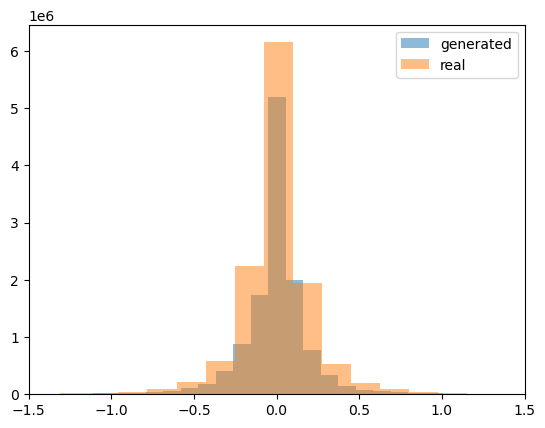

In [10]:
# Wasserstein Distance
wdr = wasserstein_distance(signal_gen.flatten(), signal.flatten())
# visualize amplitude histograms
plt.hist(x_gen.flatten(), bins=100, alpha=0.5, label='generated')
plt.hist(x.flatten(), bins=100, alpha=0.5, label='real')
plt.xlim(-1.5, 1.5)
plt.legend()
plt.show()

## Model comparison

In [ ]:
ls = range(20, 1300, 20)
fids = np.zeros([len(ls), 3])

for i in ls:
    model_path = f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras'
    print(f'Epoch {i}')
    wgan_gp.load_weights(model_path)

    x_gen = wgan_gp.generator(keras.random.normal((len(x), 64), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                                pos).cpu().detach()

    signal_gen = x_gen.squeeze().numpy()

    # compute FID on hjorth parameters
    for j, func in enumerate([hjorth_parameters, spectral_features, time_domain_features]):
        real_f = func(signal)
        gen_f = func(signal_gen)
        fid = compute_fid(real_f, gen_f)
        fids[i//20-1, j] = fid

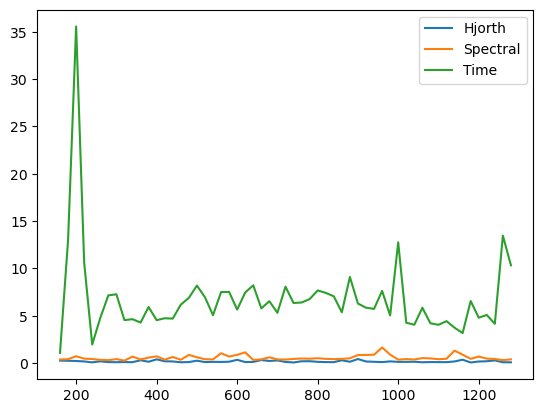

In [69]:
plt.plot(ls[7:], fids[7:, 0], label='Hjorth')
plt.plot(ls[7:], fids[7:, 1], label='Spectral')
plt.plot(ls[7:], fids[7:, 2], label='Time')
plt.legend()

## Using best model for downstream task

In [ ]:
from sklearn.model_selection import GroupShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Gender labels
y = xarray.gender[~xarray.subject.isin(exclude_sub_ids)]
y -= 1
y = y.reshape(-1, 1).repeat(x.shape[0]//n_subject, 1).flatten()

In [11]:
# Model
# intermediate feature extraction using the best model ls[np.argmin(fids.sum(axis=1))]  # 160
i = 1260
model_path = f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_best_gloss.model.keras'
wgan_gp.load_weights(model_path)

# X features
f_extractor = keras.Model(wgan_gp.critic.model.layers[0].input, wgan_gp.critic.model.layers[10].output)  # intermediate layer
features = f_extractor(x.float()).cpu().detach().numpy()

In [12]:
# Classifier
cv_g = GroupShuffleSplit(n_splits=10, test_size=0.2)

pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='sigmoid', class_weight='balanced')),
])

scores_g = cross_val_score(pipe, features, y, cv=cv_g, groups=sub, n_jobs=-1)
print(f'Accuracy: {np.array(scores_g).mean() * 100:.2f}%', f'±{np.array(scores_g).std() * 100:.2f}%')

Accuracy: 52.28% ±2.09%


## Visualize inetermediate neurons activations

In [ ]:
# helper functions for plotting
def plot_neurons_act(features, across_batch=False, from_to=(20, 40), batch=0, xlim=1024):
    plt.figure(figsize=(20, 2))
    if len(features.shape) == 3:
        if across_batch:
            for i in range(from_to[0], from_to[1]):
                plt.plot(features[i, :, 0])
        else:
            for i in range(0, features.shape[2]):
                plt.plot(features[batch, :, i])

    if len(features.shape) == 2:
        for i in range(from_to[0], from_to[1]):
            plt.plot(features[i, :])
    plt.xlim(0, xlim)
    plt.show()
i = 1260

(11940, 512, 1)


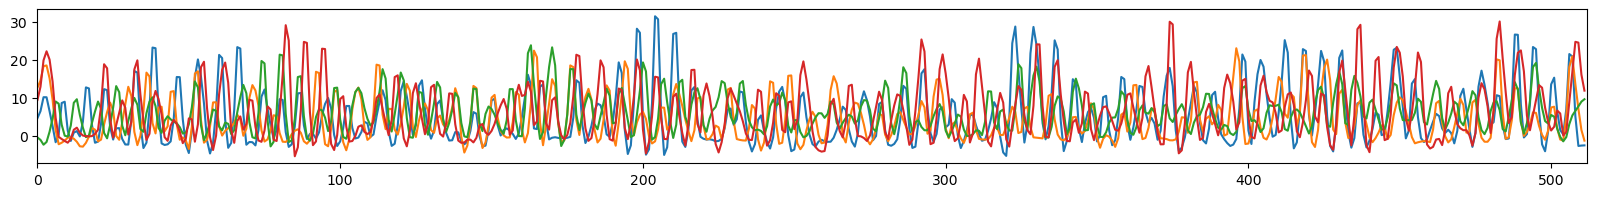

In [139]:
model_path = f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras'
wgan_gp.load_weights(model_path)

generator = wgan_gp.generator
latent_dim=64
features = keras.Model(generator.model.layers[0].input, generator.model.layers[5].output)(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std())).cpu().detach().numpy()
print(features.shape)
plot_neurons_act(features, across_batch=True, from_to=(1000, 1004), xlim=features.shape[1])

## Critics performance

In [ ]:
from pathlib import Path
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def print_D_performance(x, sub):
    return sigmoid(wgan_gp.critic(x.float().to('mps'), torch.tensor(sub).to('mps')).mean().item())

critic_performances_real = {}
critic_performances_gen = {}

for i in range(20, 1840, 20):
    dir = Path(f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras')
    wgan_gp.load_weights(dir)
    x_gen = wgan_gp.generator(keras.random.normal((len(x), 64), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                              pos).cpu().detach()
    print(f'>>>>>> {dir.stem.split(".")[2][5:]}')
    critic_performances_real[dir.stem.split(".")[2][5:]] = print_D_performance(x, sub)
    critic_performances_gen[dir.stem.split(".")[2][5:]] = print_D_performance(x_gen, sub)

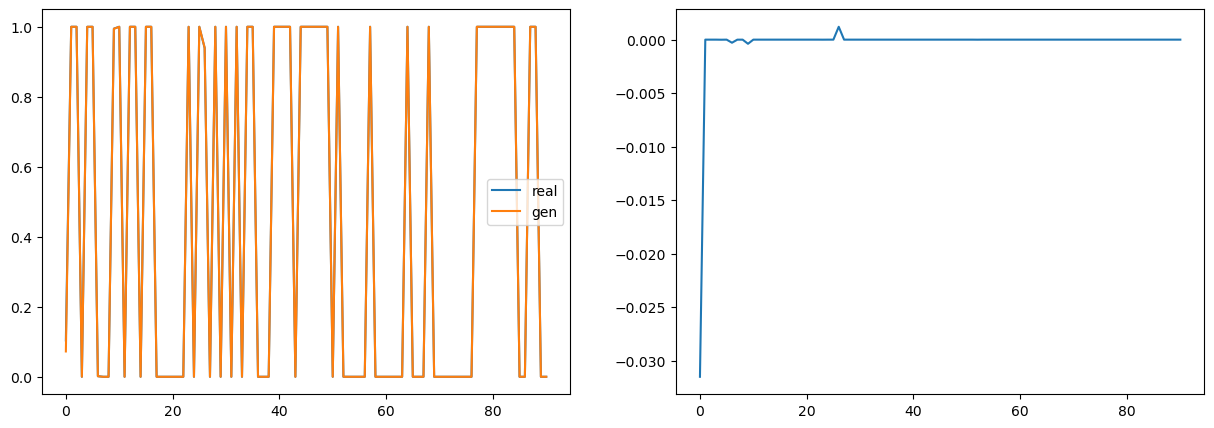

In [146]:
# concatenate critic performances
critic_performances = pd.concat([pd.Series(critic_performances_real), pd.Series(critic_performances_gen)], axis=1)

# difference in critic performances
critic_performances['diff'] = critic_performances.iloc[:, 1] - critic_performances.iloc[:, 0]
# plot critic performances
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(list(critic_performances_real.values()), label='real')
axes[0].plot(list(critic_performances_gen.values()), label='gen')
axes[1].plot(critic_performances['diff'].values, label='diff')
axes[0].legend()
plt.show()

## Visual Inspection of X_gen vs. X

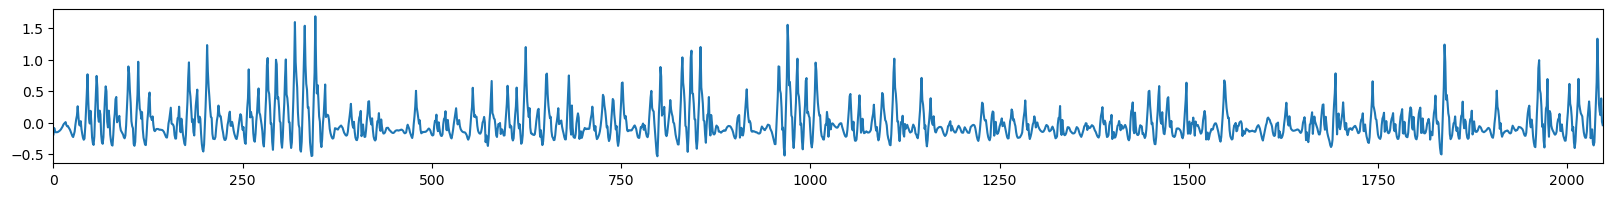

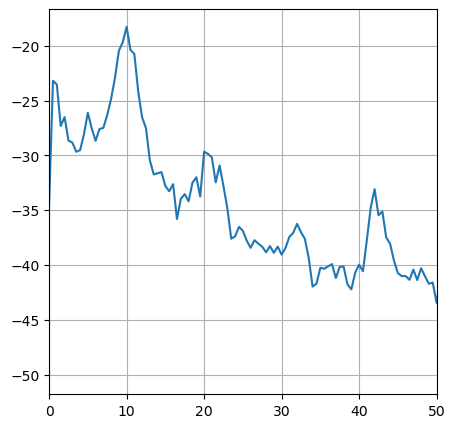

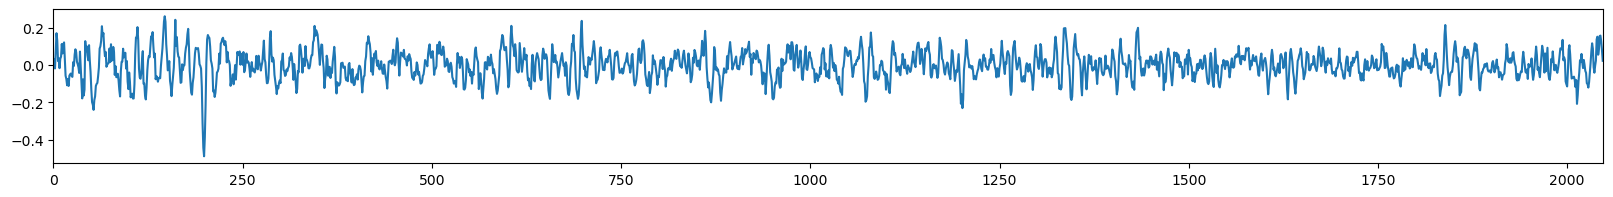

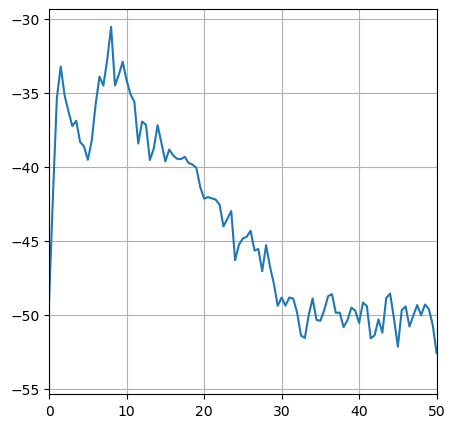

In [12]:
sub = 2
d = 2*1024
s = 10
def plot_segment(x, sub, seg, duration=d, db=False):
    x1 = x[sub*60:(sub+1)*60].flatten()
    plt.figure(figsize=(20, 2))
    segment = x1[seg*duration:(seg+1)*duration]
    plt.plot(segment)
    plt.xlim(0, duration)
    plt.show()
    f, Pxx = welch(segment, fs=128, nperseg=256)
    if db:
        Pxx = 10*np.log10(Pxx)
    plt.figure(figsize=(5, 5))
    plt.plot(f, Pxx)
    plt.xlim(0, 50)
    plt.grid()
    plt.show()

plot_segment(x_gen, sub, s, db=True)
plot_segment(x, sub, s, d, db=True)

## Model & Training

In [ ]:
# 2. MODEL and Plot generated data by the model before training
load_model = True
i = 160
model_path = f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras'
latent_dim = 64
wgan_gp = WGAN_GP(time_dim=time_dim, feature_dim=len(channels), latent_dim=latent_dim, n_subjects=n_subject, use_sublayer_generator=True,
                  use_sublayer_critic=False, use_channel_merger=False, kerner_initializer='glorot_uniform',
                  interpolation='bilinear')
if load_model:
    wgan_gp.load_weights(model_path)

x_gen = wgan_gp.generator(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                          pos).cpu().detach()

In [ ]:
torch.cuda.empty_cache() # clear GPU memory before training
step_losses_history = StepLossHistory()

# 3. TRAINING
wgan_gp.compile(d_optimizer=keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9),
                g_optimizer=keras.optimizers.Adam(0.001, beta_1=0.5, beta_2=0.9),
                gradient_penalty_weight=10.0)

# early stopping callback
callbacks = [keras.callbacks.EarlyStopping(monitor='g_loss', mode='min', patience=500),
             step_losses_history]

In [ ]:
# training
batch_size = 64
history = wgan_gp.fit(data, epochs=20, batch_size=batch_size, callbacks=callbacks, shuffle=True)